# TASK 8: Fine-tuning Transformer Models with Hugging Face

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW 
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# === 1. Устройства ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 2. Датасет и токенизация ===
dataset = load_dataset("imdb")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

train_data = dataset["train"].shuffle(seed=42).select(range(5000))
val_data = dataset["test"].select(range(1000))

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
#Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#Training
num_epochs = 3
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    # === TRAIN ===
    model.train()
    correct = total = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total
    train_acc_history.append(train_acc)

    # === EVAL ===
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/3 — Train Acc: 0.8440, Val Acc: 0.9270
Epoch 2/3 — Train Acc: 0.9364, Val Acc: 0.8280
Epoch 3/3 — Train Acc: 0.9750, Val Acc: 0.8550


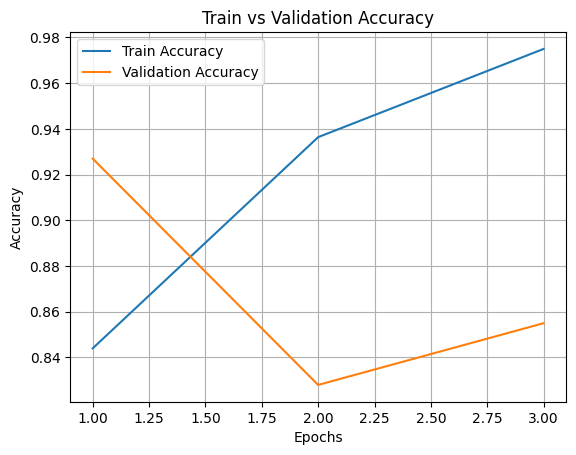

In [5]:
#Visualization
plt.plot(range(1, num_epochs+1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
